In [1]:
from absl import logging
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import fnmatch
from collections import defaultdict
import tqdm
import hashlib
import tensorflow as tf
import cv2
import random

## Audi dataset details

The bounding box dataset contains 11,754 frames. Each frame has an annotated bounding box label.

All frames are grouped in 18 different scenes with each scene contained in its corresponding folder. Scene folder names are in the 'YYYYMMDD_hhmmss' format. They represent the date and time of the recording. Each scene is further divided into four folders as mentioned below. For this project, we will be using data from two folders namely 'camera' and 'label3D'.

- 'camera': input images and json info files
- 'lidar': input 3D point clouds
- 'label': annotated label images
- 'label3D': annotated 3D bounding boxes 

Each of these folders are further divided depending on the camera from which the data was recorded. There are six
cameras available in the vehicle, therefore, the following are the camera folders:

- 'cam_front_center'
- 'cam_front_left'
- 'cam_front_right'
- 'cam_side_left'
- 'cam_side_right'
- 'cam_rear_center'

Lastly, each of these folders contains the corresponding item for each frame.
These are the filename formats for the item of a single frame:

- input RGB image: YYMMDDDDhhmmss_camera_[frontcenter|frontleft|frontright|sideleft|sideright|rearcenter]_[ID].png
- 3D Bounding Box: YYMMDDDDhhmmss_label3D_[frontcenter|frontleft|frontright|sideleft|sideright|rearcenter]_[ID].json

For example, a frame with ID 1617 from a scene recorded on 2018-08-07 14:50:28 from the front center camera would be have the following items in these locations:

- input RGB image  : 20180807_145028/camera/cam_front_center/20180807145028_camera_frontcenter_000001617.png
- 3D Bounding Box  : 20180807_145028/label3D/cam_front_center/20180807145028_label3D_frontcenter_000001617.json

In [3]:
cur_dir = os.getcwd()
dictFiles = defaultdict(list)
# Get all the filepaths for json and respective image files
for dirpath, dirname, filenames in os.walk('./data/Audi_dataset'):
    for file in filenames:
        if fnmatch.fnmatch(file, '*_label3D_*.json'):
            key = file.split('_')[3].split('.')[0].lstrip('0')
            filepath = dirpath + '/' + file
            dictFiles[key].append(filepath.lstrip('.'))
        if fnmatch.fnmatch(file, '*_camera_*.png'):
            key = file.split('_')[3].split('.')[0].lstrip('0')
            filepath = dirpath + '/' + file
            dictFiles[key].append(filepath.lstrip('.'))
# DataFrame with all the filepaths for json and respective image files
dataset = pd.DataFrame([(k, v[0],v[1]) for k, v in dictFiles.items()], columns = ['id','jsonFile','imageFile'])

dataset.info()
dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11754 entries, 0 to 11753
Data columns (total 3 columns):
id           11754 non-null object
jsonFile     11754 non-null object
imageFile    11754 non-null object
dtypes: object(3)
memory usage: 275.6+ KB


id                                           jsonFile  \
0  122788  /data/Audi_dataset/20181204_135952/label3D/cam...   
1   80971  /data/Audi_dataset/20181204_135952/label3D/cam...   
2   87534  /data/Audi_dataset/20181204_135952/label3D/cam...   
3  113606  /data/Audi_dataset/20181204_135952/label3D/cam...   
4   36780  /data/Audi_dataset/20181204_135952/label3D/cam...   

                                           imageFile  
0  /data/Audi_dataset/20181204_135952/camera/cam_...  
1  /data/Audi_dataset/20181204_135952/camera/cam_...  
2  /data/Audi_dataset/20181204_135952/camera/cam_...  
3  /data/Audi_dataset/20181204_135952/camera/cam_...  
4  /data/Audi_dataset/20181204_135952/camera/cam_...

### For object annotations, we will be using the '2d_bbox' details and its corresponding 'class' labels provided in the json file for each image.

In [7]:
df = pd.DataFrame()
# Read the json files to get the 2D and 3D boxes details 
for key, row in tqdm.tqdm(dataset.iterrows()):
    d = pd.read_json(cur_dir+row['jsonFile'])
    height, width = plt.imread(cur_dir + row['imageFile']).shape[:2]
    d = d.loc[['2d_bbox','class']].transpose()
    d['id'] = row['id']
    d['width'] = width
    d['height'] = height
    df = pd.concat([df,d],sort=True)
    
audiDf = pd.merge(dataset, df, on='id', how='inner')
audiDf['x1'] = audiDf['2d_bbox'].str[0] #2d_bbox_left
audiDf['y1'] = audiDf['2d_bbox'].str[1] #2d_bbox_top
audiDf['x2'] = audiDf['2d_bbox'].str[2] #2d_bbox_right
audiDf['y2'] = audiDf['2d_bbox'].str[3] #2d_bbox_bottom

11754it [23:11,  8.01it/s]


In [8]:
#audiDf.to_csv('data/audi_dataset.csv')

In [2]:
audiDf = pd.read_csv('data/audi_dataset.csv', index_col=0)

In [3]:
audiDf.head()

id                                           jsonFile  \
0  122788  /data/Audi_dataset/20181204_135952/label3D/cam...   
1   80971  /data/Audi_dataset/20181204_135952/label3D/cam...   
2   80971  /data/Audi_dataset/20181204_135952/label3D/cam...   
3   87534  /data/Audi_dataset/20181204_135952/label3D/cam...   
4   87534  /data/Audi_dataset/20181204_135952/label3D/cam...   

                                           imageFile  \
0  /data/Audi_dataset/20181204_135952/camera/cam_...   
1  /data/Audi_dataset/20181204_135952/camera/cam_...   
2  /data/Audi_dataset/20181204_135952/camera/cam_...   
3  /data/Audi_dataset/20181204_135952/camera/cam_...   
4  /data/Audi_dataset/20181204_135952/camera/cam_...   

                                     2d_bbox  class  height  width         x1  \
0   [1546.853, 731.8743, 2600.568, 1212.974]    Car    1208   1920  1546.8530   
1     [100.1629, 584.1248, 373.4479, 694.48]  Truck    1208   1920   100.1629   
2   [1068.235, 330.0452, 1578.198, 918.1988]  Truck    1208   1920  1068.2350   
3     [1164.702, 511.1872, 1546.12, 868.445]  Truck    1208   1920  1164.7020   
4  [-672.8669, 446.4352, 334.3822, 909.3825]  Truck    1208   1920  -672.8669   

         y1         x2         y2  
0  731.8743  2600.5680  1212.9740  
1  584.1248   373.4479   694.4800  
2  330.0452  1578.1980   918.1988  
3  511.1872  1546.1200   868.4450  
4  446.4352   334.3822   909.3825

### Check the annotations for one of the image

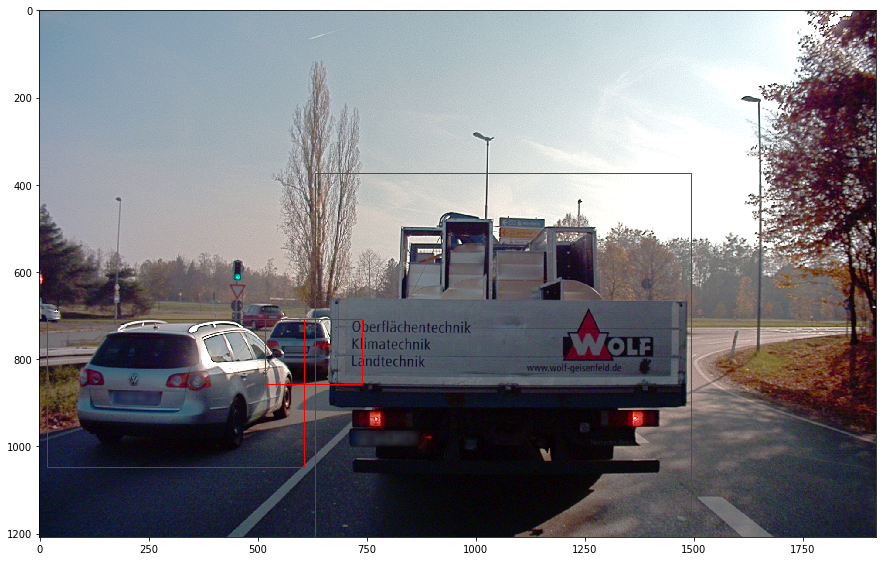

In [11]:
cur_dir = os.getcwd()
s = audiDf[audiDf.imageFile.str.contains('20181107133258_camera_frontcenter_000000484')]
img = plt.imread(cur_dir+s['imageFile'].iloc[0])
figure, ax = plt.subplots(1, figsize=(15,15))
for key, row in s.iterrows():
    topleft_x = row['x1']
    topleft_y = row['y1']
    bottom_right_x = row['x2']
    bottom_right_y = row['y2']
    rect = plt.Rectangle((topleft_x,topleft_y),(bottom_right_x-topleft_x),(bottom_right_y-topleft_y), 
                         edgecolor='r', facecolor="none")
    _ = ax.add_patch(rect)
_ = plt.imshow(img)

### Total count of labels in whole dataset

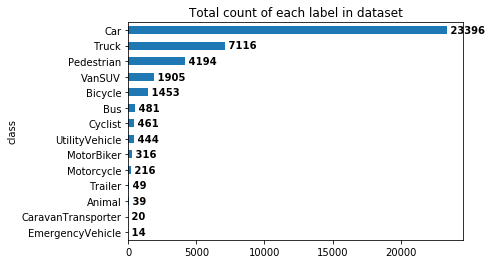

In [12]:
s = audiDf.groupby(['class']).size().sort_values(ascending=True)
ax = s.plot(kind='barh')
[ax.text(v, i, " "+str(v), va='center', fontweight='bold') for i, v in enumerate(s)];
_ = plt.title('Total count of each label in dataset')

In [4]:
class HorizontalFlip(object):

    """Horizontally flips the Image with the probability 1
    """
    def __init__(self):
        pass

    def __call__(self, img, bboxes):
        img_center = np.array(img.shape[:2])[::-1]/2
        img_center = np.hstack((img_center, img_center))

        img = img[:, ::-1, :]
        bboxes[:, [0, 2]] += 2*(img_center[[0, 2]] - bboxes[:, [0, 2]])

        box_w = abs(bboxes[:, 0] - bboxes[:, 2])

        bboxes[:, 0] -= box_w
        bboxes[:, 2] += box_w

        return img, bboxes

class Rotate(object):
    """Rotates an image    
    Bounding boxes which have an area of less than 25% in the remaining in the 
    transformed image is dropped. The resolution is maintained, and the remaining
    area if any is filled by black color.
    """

    def __init__(self, angle):
        self.angle = angle
        

    def __call__(self, img, bboxes):
        angle = self.angle        
        w,h = img.shape[1], img.shape[0]
        cx, cy = w//2, h//2        
        corners = get_corners(bboxes)        
        corners = np.hstack((corners, bboxes[:,4:]))

        img = rotate_im(img, angle)        
        corners[:,:8] = rotate_box(corners[:,:8], angle, cx, cy, h, w)                        
        new_bbox = get_enclosing_box(corners)
                
        scale_factor_x = img.shape[1] / w        
        scale_factor_y = img.shape[0] / h        
        img = cv2.resize(img, (w,h))        
        new_bbox[:,:4] /= [scale_factor_x, scale_factor_y, scale_factor_x, scale_factor_y]                 
        bboxes  = new_bbox
        bboxes = clip_box(bboxes, [0,0,w, h], 0.25)
        
        return img, bboxes

                     
class Sequence(object):
    def __init__(self, augmentations, probs = 1):

        
        self.augmentations = augmentations
        self.probs = probs
        
    def __call__(self, images, bboxes):
        for i, augmentation in enumerate(self.augmentations):
            if type(self.probs) == list:
                prob = self.probs[i]
            else:
                prob = self.probs
                
            if random.random() < prob:
                images, bboxes = augmentation(images, bboxes)
        return images, bboxes

In [5]:
def draw_rect(im, cords, color = None):
    """Draw the rectangle on the image
    """    
    im = im.copy()
    
    cords = cords[:,:4]
    cords = cords.reshape(-1,4)
    if not color:
        color = [255,255,255]
    for cord in cords:
        
        pt1, pt2 = (cord[0], cord[1]) , (cord[2], cord[3])
                
        pt1 = int(pt1[0]), int(pt1[1])
        pt2 = int(pt2[0]), int(pt2[1])
    
        im = cv2.rectangle(im.copy(), pt1, pt2, color, int(max(im.shape[:2])/200))
    return im

def bbox_area(bbox):
    return (bbox[:,2] - bbox[:,0])*(bbox[:,3] - bbox[:,1])
        
def clip_box(bbox, clip_box, alpha):
    """Clip the bounding boxes to the borders of an image
    """
    ar_ = (bbox_area(bbox))
    x_min = np.maximum(bbox[:,0], clip_box[0]).reshape(-1,1)
    y_min = np.maximum(bbox[:,1], clip_box[1]).reshape(-1,1)
    x_max = np.minimum(bbox[:,2], clip_box[2]).reshape(-1,1)
    y_max = np.minimum(bbox[:,3], clip_box[3]).reshape(-1,1)
    
    bbox = np.hstack((x_min, y_min, x_max, y_max, bbox[:,4:]))    
    delta_area = ((ar_ - bbox_area(bbox))/ar_)    
    mask = (delta_area < (1 - alpha)).astype(int)    
    bbox = bbox[mask == 1,:]
    return bbox


def rotate_im(image, angle):
    """Rotate the image.   
    Rotate the image such that the rotated image is enclosed inside the tightest
    rectangle. The area not occupied by the pixels of the original image is colored
    black. 
    """
    # grab the dimensions of the image and then determine the
    # centre
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # perform the actual rotation and return the image
    image = cv2.warpAffine(image, M, (nW, nH))

    return image

def get_corners(bboxes):
    """Get corners of bounding boxes    
    """
    width = (bboxes[:,2] - bboxes[:,0]).reshape(-1,1)
    height = (bboxes[:,3] - bboxes[:,1]).reshape(-1,1)
    
    x1 = bboxes[:,0].reshape(-1,1)
    y1 = bboxes[:,1].reshape(-1,1)
    
    x2 = x1 + width
    y2 = y1 
    
    x3 = x1
    y3 = y1 + height
    
    x4 = bboxes[:,2].reshape(-1,1)
    y4 = bboxes[:,3].reshape(-1,1)
    
    corners = np.hstack((x1,y1,x2,y2,x3,y3,x4,y4))
    
    return corners

def rotate_box(corners,angle,  cx, cy, h, w):
    """Rotate the bounding box.
    """

    corners = corners.reshape(-1,2)
    corners = np.hstack((corners, np.ones((corners.shape[0],1), dtype = type(corners[0][0]))))
    
    M = cv2.getRotationMatrix2D((cx, cy), angle, 1.0)    
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cx
    M[1, 2] += (nH / 2) - cy
    # Prepare the vector to be transformed
    calculated = np.dot(M,corners.T).T
    
    calculated = calculated.reshape(-1,8)
    
    return calculated


def get_enclosing_box(corners):
    """Get an enclosing box for ratated corners of a bounding box
    """
    x_ = corners[:,[0,2,4,6]]
    y_ = corners[:,[1,3,5,7]]
    
    xmin = np.min(x_,1).reshape(-1,1)
    ymin = np.min(y_,1).reshape(-1,1)
    xmax = np.max(x_,1).reshape(-1,1)
    ymax = np.max(y_,1).reshape(-1,1)
    
    final = np.hstack((xmin, ymin, xmax, ymax,corners[:,8:]))
    
    return final

def letterbox_image(img, inp_dim):
    '''resize image with unchanged aspect ratio using padding
    '''

    inp_dim = (inp_dim, inp_dim)
    img_w, img_h = img.shape[1], img.shape[0]
    w, h = inp_dim
    new_w = int(img_w * min(w/img_w, h/img_h))
    new_h = int(img_h * min(w/img_w, h/img_h))
    resized_image = cv2.resize(img, (new_w,new_h))
    
    canvas = np.full((inp_dim[1], inp_dim[0], 3), 0)

    canvas[(h-new_h)//2:(h-new_h)//2 + new_h,(w-new_w)//2:(w-new_w)//2 + new_w,  :] = resized_image
    
    return canvas

### The audi dataset is split into training, validation and testing set

In [4]:
train_dataset, test_dataset, val_dataset = np.split(dataset.sample(frac=1), 
                                                    [int(.7*len(dataset)), int(.8*len(dataset))])
train_dataset.shape, test_dataset.shape, val_dataset.shape

((8227, 3), (1176, 3), (2351, 3))

### audi_convert() method is created for converting the audi data annotations to tfrecord format, so that this tfrecord data can be given directly to the YOLO model for training and validation.

### build_example() method is iterrating over each row in audi dataframe and converting it to tf.example format which is later serialized in audi_convert() method.

In [6]:
train_dataset = pd.read_csv('Data/train.csv', index_col = 0)
train_dataset.shape

(8227, 3)

In [7]:
audiDf.x1 = np.where(audiDf.x1 < 0, 0, audiDf.x1)
audiDf.y1 = np.where(audiDf.y1 < 0, 0, audiDf.y1)
audiDf.x2 = np.where(audiDf.x2 < 0, 0, audiDf.x2)
audiDf.y2 = np.where(audiDf.y2 < 0, 0, audiDf.y2)

audiDf.x1 = np.where(audiDf.x1/audiDf.width > 1, audiDf.width, audiDf.x1)
audiDf.y1 = np.where(audiDf.y1/audiDf.height > 1, audiDf.height, audiDf.y1)
audiDf.x2 = np.where(audiDf.x2/audiDf.width > 1, audiDf.width, audiDf.x2)
audiDf.y2 = np.where(audiDf.y2/audiDf.height > 1, audiDf.height, audiDf.y2)
audiDf.to_csv('Data/audi_converted.csv')

In [8]:
classesFile = './Data/classes.txt'
classNames = ['Bus','Cyclist','UtilityVehicle','MotorBiker','Motorcycle','Trailer',
              'Animal','CaravanTransporter','EmergencyVehicle','Bicycle','VanSUV']

def audi_convert(data, isTrain):
    class_map = {name: idx for idx, name in enumerate(
        open(classesFile).read().splitlines())}
    logging.info("Class mapping loaded: %s", class_map)

    writer = tf.io.TFRecordWriter(output_file)

    if isTrain:
        aug_data = audiDf[audiDf.id.isin(data.id)]
        aug_data = aug_data[aug_data['class'].isin(classNames)]
        for key, row in tqdm.tqdm(aug_data.iterrows()):
            img = plt.imread(cur_dir+row['imageFile'])
            bboxes = row[['x1','y1','x2','y2']].values.reshape((1,4))
            transforms = HorizontalFlip()
            imgH, bboxesH = transforms(img, bboxes)
            tf_example = build_train_example(row, class_map, imgH, bboxesH)
            writer.write(tf_example.SerializeToString())
            
            img = plt.imread(cur_dir+row['imageFile'])
            bboxes = row[['x1','y1','x2','y2']].values.reshape((1,4))
            transforms = Rotate(20)
            imgR, bboxesR = transforms(img, bboxes)
            tf_example = build_train_example(row, class_map, imgR, bboxesR)
            writer.write(tf_example.SerializeToString())
            
            img = plt.imread(cur_dir+row['imageFile'])
            bboxes = row[['x1','y1','x2','y2']].values.reshape((1,4))
            transforms = Sequence([HorizontalFlip(), Rotate(10)])
            imgS, bboxesS = transforms(img, bboxes)
            tf_example = build_train_example(row, class_map, imgS, bboxesS)
            writer.write(tf_example.SerializeToString())
       
    for key, row in tqdm.tqdm(data.iterrows()):
        tf_example = build_example(row, class_map)
        writer.write(tf_example.SerializeToString())
        
    writer.close()
    logging.info("Done")

In [9]:
def build_example(row, class_map):
    d = pd.read_json(cur_dir + row['jsonFile'])
    d = d.loc[['2d_bbox','class']].transpose()    
    img_path = cur_dir + row['imgFile']
    height, width = plt.imread(img_path).shape[:2]
    img_raw = open(img_path, 'rb').read()
    key = hashlib.sha256(img_raw).hexdigest()

    xmin = []
    ymin = []
    xmax = []
    ymax = []
    classes = []
    classes_text = []
   
    for k, val in d.iterrows():
        x1 = val['2d_bbox'][0] if val['2d_bbox'][0] > 0 else 0
        y1 = val['2d_bbox'][1] if val['2d_bbox'][1] > 0 else 0
        x2 = val['2d_bbox'][2] if val['2d_bbox'][2] > 0 else 0
        y2 = val['2d_bbox'][3] if val['2d_bbox'][3] > 0 else 0
        
        xminval = (float(x1) / width) if (float(x1) / width) < 1 else 1
        yminval = (float(y1) / height) if (float(y1) / height) < 1 else 1
        xmaxval = (float(x2) / width) if (float(x2) / width) < 1 else 1
        ymaxval = (float(y2) / height) if (float(y2) / height) < 1 else 1
        
        xmin.append(xminval)
        ymin.append(yminval)
        xmax.append(xmaxval)
        ymax.append(ymaxval)
        classes_text.append(val['class'].encode('utf8'))
        classes.append(class_map[val['class']])

    example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width': tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/filename': tf.train.Feature(bytes_list=tf.train.BytesList(value=[
            row['imgFile'].encode('utf8')])),
        'image/source_id': tf.train.Feature(bytes_list=tf.train.BytesList(value=[
            row['imgFile'].encode('utf8')])),
        'image/key/sha256': tf.train.Feature(bytes_list=tf.train.BytesList(value=[key.encode('utf8')])),
        'image/encoded': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_raw])),
        'image/format': tf.train.Feature(bytes_list=tf.train.BytesList(value=['png'.encode('utf8')])),
        'image/object/bbox/xmin': tf.train.Feature(float_list=tf.train.FloatList(value=xmin)),
        'image/object/bbox/xmax': tf.train.Feature(float_list=tf.train.FloatList(value=xmax)),
        'image/object/bbox/ymin': tf.train.Feature(float_list=tf.train.FloatList(value=ymin)),
        'image/object/bbox/ymax': tf.train.Feature(float_list=tf.train.FloatList(value=ymax)),
        'image/object/class/text': tf.train.Feature(bytes_list=tf.train.BytesList(value=classes_text)),
        'image/object/class/label': tf.train.Feature(int64_list=tf.train.Int64List(value=classes)),
    }))

    return example

In [10]:
def build_train_example(row, class_map, img, bboxes):
    plt.imsave('Data/out.png', img)
    img_raw = open('Data/out.png', 'rb').read()
    #plt.imread('data/out.png')
    #byte = bytearray(img)
    #img_raw = Image.open(img).read()
    #img_raw = bytes(img).read()
    key = hashlib.sha256(img_raw).hexdigest()
    height = row['height']
    width = row['width']

    xmin = []
    ymin = []
    xmax = []
    ymax = []
    classes = []
    classes_text = []
   
    x1 = bboxes[0][0] if bboxes[0][0] > 0 else 1
    y1 = bboxes[0][1] if bboxes[0][1] > 0 else 1
    x2 = bboxes[0][2] if bboxes[0][2] > 0 else 1
    y2 = bboxes[0][3] if bboxes[0][3] > 0 else 1
        
    xminval = (float(x1) / width) if (float(x1) / width) < 1 else 1
    yminval = (float(y1) / height) if (float(y1) / height) < 1 else 1
    xmaxval = (float(x2) / width) if (float(x2) / width) < 1 else 1
    ymaxval = (float(y2) / height) if (float(y2) / height) < 1 else 1
        
    xmin.append(xminval)
    ymin.append(yminval)
    xmax.append(xmaxval)
    ymax.append(ymaxval)
    classes_text.append(row['class'].encode('utf8'))
    classes.append(class_map[row['class']])  

    example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width': tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/filename': tf.train.Feature(bytes_list=tf.train.BytesList(value=[
            row['imageFile'].encode('utf8')])),
        'image/source_id': tf.train.Feature(bytes_list=tf.train.BytesList(value=[
            row['imageFile'].encode('utf8')])),
        'image/key/sha256': tf.train.Feature(bytes_list=tf.train.BytesList(value=[key.encode('utf8')])),
        'image/encoded': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_raw])),
        'image/format': tf.train.Feature(bytes_list=tf.train.BytesList(value=['png'.encode('utf8')])),
        'image/object/bbox/xmin': tf.train.Feature(float_list=tf.train.FloatList(value=xmin)),
        'image/object/bbox/xmax': tf.train.Feature(float_list=tf.train.FloatList(value=xmax)),
        'image/object/bbox/ymin': tf.train.Feature(float_list=tf.train.FloatList(value=ymin)),
        'image/object/bbox/ymax': tf.train.Feature(float_list=tf.train.FloatList(value=ymax)),
        'image/object/class/text': tf.train.Feature(bytes_list=tf.train.BytesList(value=classes_text)),
        'image/object/class/label': tf.train.Feature(int64_list=tf.train.Int64List(value=classes)),
    }))

    return example

In [19]:
output_file = './data/audi_train.tfrecord'
audi_convert(train_dataset)

8227it [31:53,  4.35it/s]


In [15]:
output_file = './data/audi_val.tfrecord'
audi_convert(val_dataset)

2351it [04:29,  8.94it/s]


In [11]:
output_file = './Data/audi_training.tfrecord'
cur_dir = os.getcwd()
audi_convert(train_dataset, True)

3713it [3:12:59,  2.99s/it]
8227it [35:38,  3.98it/s]


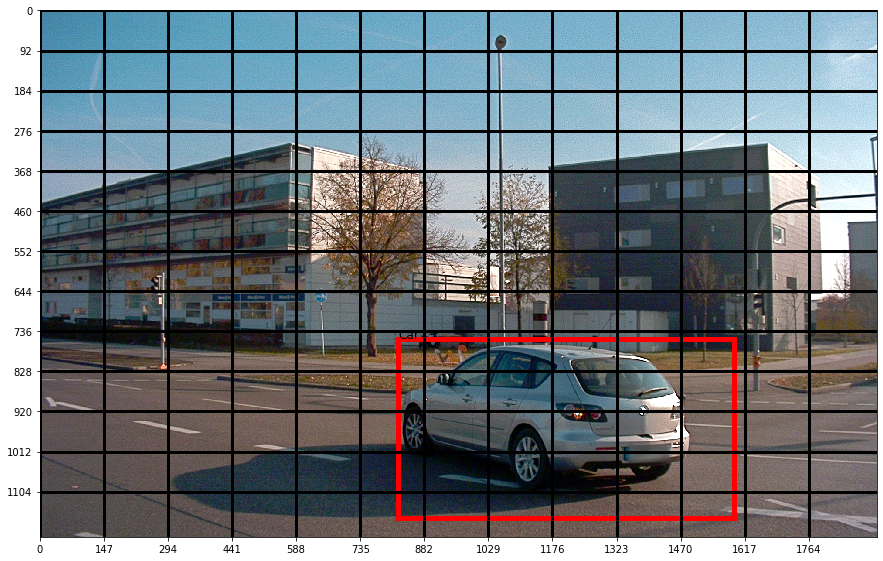

In [15]:
audiDf = pd.read_csv('data/audi_dataset.csv', index_col=0)
cur_dir = os.getcwd()
s = audiDf[audiDf.imageFile.str.contains('20181107132300_camera_frontcenter_000002892')]
img = plt.imread(cur_dir+s['imageFile'].iloc[0])
figure, ax = plt.subplots(1, figsize=(15,15))
for key, row in s.iterrows():
    topleft_x = row['x1']
    topleft_y = row['y1']
    bottom_right_x = row['x2']
    bottom_right_y = row['y2']
    rect1 = plt.Rectangle((topleft_x,topleft_y),(bottom_right_x-topleft_x),(bottom_right_y-topleft_y), 
                         edgecolor='r', facecolor='none', linewidth=5)
    #rect2 = plt.Rectangle((topleft_x-30,topleft_y+80),(bottom_right_x-topleft_x),(bottom_right_y-topleft_y), 
    #                     edgecolor='r', facecolor='none', linewidth=5)
    #rect3 = plt.Rectangle((topleft_x+50,topleft_y-30),(bottom_right_x-topleft_x),(bottom_right_y-topleft_y), 
    #                     edgecolor='r', facecolor='none', linewidth=5)
    plt.text(topleft_x, topleft_y, row['class'], fontsize=12)
    _ = ax.add_patch(rect1)
    #_ = ax.add_patch(rect2)
    #_ = ax.add_patch(rect3)
    ax.grid(which='major', axis='both', linestyle='-', color='black', linewidth=3)
_ = plt.xticks((0,147,294,441,588,735,882,1029,1176,1323,1470,1617,1764))
_ = plt.yticks((0,92,184,276,368,460,552,644,736,828,920,1012,1104))
_ = plt.imshow(img)

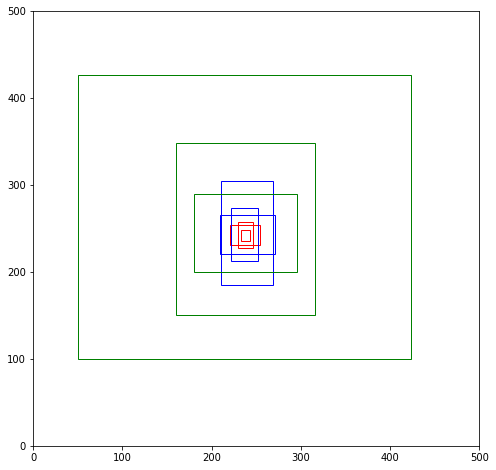

In [16]:
#anchors = [(10, 13), (16, 30), (33, 23), (30, 61), (62, 45),
#                         (59, 119), (116, 90), (156, 198), (373, 326)]

#from matplotlib.patches import Rectangle 
fig, ax = plt.subplots(figsize=(8,8))
rect1 = plt.Rectangle((233,235),(10),(13) , edgecolor='r', facecolor='none')
rect2 = plt.Rectangle((230,227),(16),(30) , edgecolor='r', facecolor='none')
rect3 = plt.Rectangle((221,231),(33),(23) , edgecolor='r', facecolor='none')
rect4 = plt.Rectangle((222,212),(30),(61) , edgecolor='b', facecolor='none')
rect5 = plt.Rectangle((209,220),(62),(45) , edgecolor='b', facecolor='none')
rect6 = plt.Rectangle((210,185),(59),(119), edgecolor='b', facecolor='none')
rect7 = plt.Rectangle((180,200),(116),(90), edgecolor='g', facecolor='none')
rect8 = plt.Rectangle((160,150),(156),(198),edgecolor='g', facecolor='none')
rect9 = plt.Rectangle((50,100),(373),(326), edgecolor='g', facecolor='none')

_ = ax.add_patch(rect1)
_ = ax.add_patch(rect2)
_ = ax.add_patch(rect3)
_ = ax.add_patch(rect4)
_ = ax.add_patch(rect5)
_ = ax.add_patch(rect6)
_ = ax.add_patch(rect7)
_ = ax.add_patch(rect8)
_ = ax.add_patch(rect9)

ax.set_xlim([0, 500])
ax.set_ylim([0, 500])
_ = plt.show()

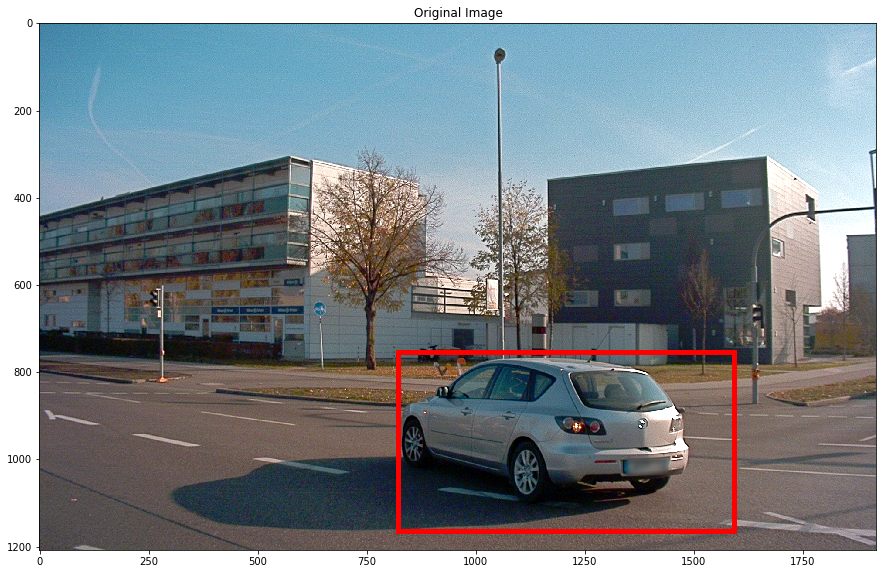

In [17]:
audiDf = pd.read_csv('data/audi_dataset.csv', index_col=0)
cur_dir = os.getcwd()
s = audiDf[audiDf.imageFile.str.contains('20181107132300_camera_frontcenter_000002892')]
img = plt.imread(cur_dir+s['imageFile'].iloc[0])
bboxes = s[['x1','y1','x2','y2']].values.reshape((1,4))
figure, ax = plt.subplots(1, figsize=(15,15))

topleft_x = bboxes[0][0]
topleft_y = bboxes[0][1]
bottom_right_x = bboxes[0][2]
bottom_right_y = bboxes[0][3]
rect1 = plt.Rectangle((topleft_x,topleft_y),(bottom_right_x-topleft_x),(bottom_right_y-topleft_y), 
                         edgecolor='r', facecolor='none', linewidth=5)

_ = ax.add_patch(rect1)
_ = plt.imshow(img)
_ = plt.title('Original Image')

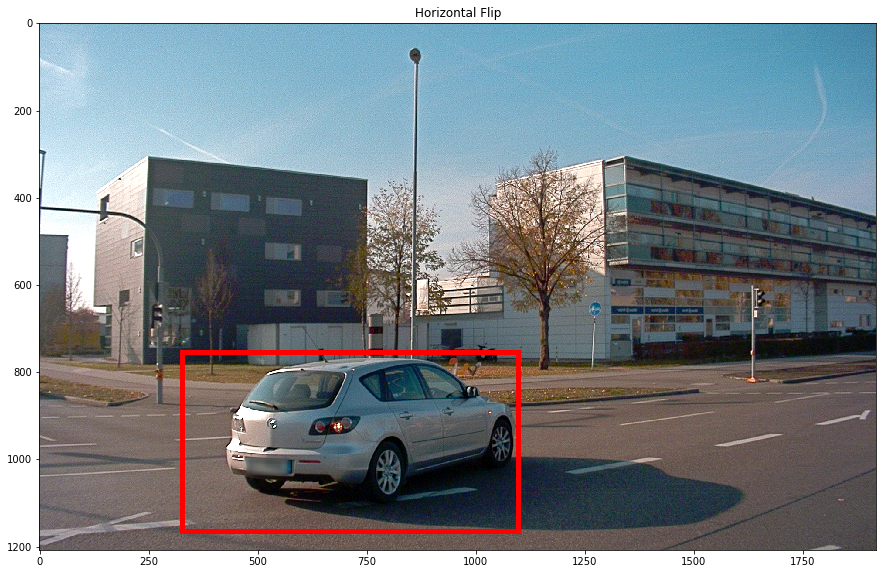

In [18]:
figure, ax = plt.subplots(1, figsize=(15,15))
img = plt.imread(cur_dir+s['imageFile'].iloc[0])
bboxes = s[['x1','y1','x2','y2']].values.reshape((1,4))
transforms = HorizontalFlip()
imgH, bboxesH = transforms(img, bboxes)

topleft_x = bboxesH[0][0]
topleft_y = bboxesH[0][1]
bottom_right_x = bboxesH[0][2]
bottom_right_y = bboxesH[0][3]
rect1 = plt.Rectangle((topleft_x,topleft_y),(bottom_right_x-topleft_x),(bottom_right_y-topleft_y), 
                         edgecolor='r', facecolor='none', linewidth=5)

_ = ax.add_patch(rect1)
_ = plt.imshow(imgH)
_ = plt.title('Horizontal Flip')

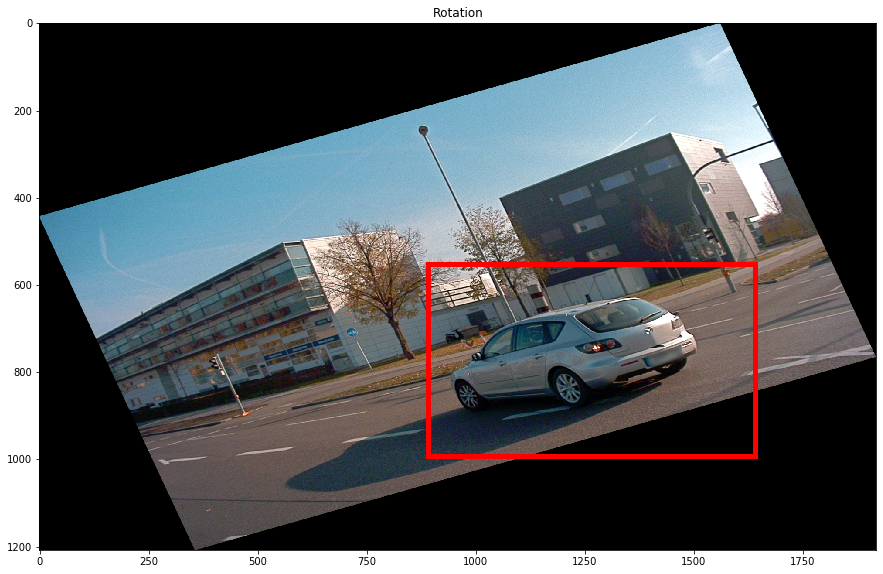

In [19]:
figure, ax = plt.subplots(1, figsize=(15,15))
img = plt.imread(cur_dir+s['imageFile'].iloc[0])
bboxes = s[['x1','y1','x2','y2']].values.reshape((1,4))
transforms = Rotate(20)
imgR, bboxesR = transforms(img, bboxes)

topleft_x = bboxesR[0][0]
topleft_y = bboxesR[0][1]
bottom_right_x = bboxesR[0][2]
bottom_right_y = bboxesR[0][3]
rect1 = plt.Rectangle((topleft_x,topleft_y),(bottom_right_x-topleft_x),(bottom_right_y-topleft_y), 
                         edgecolor='r', facecolor='none', linewidth=5)

_ = ax.add_patch(rect1)
_ = plt.imshow(imgR)
_ = plt.title('Rotation')

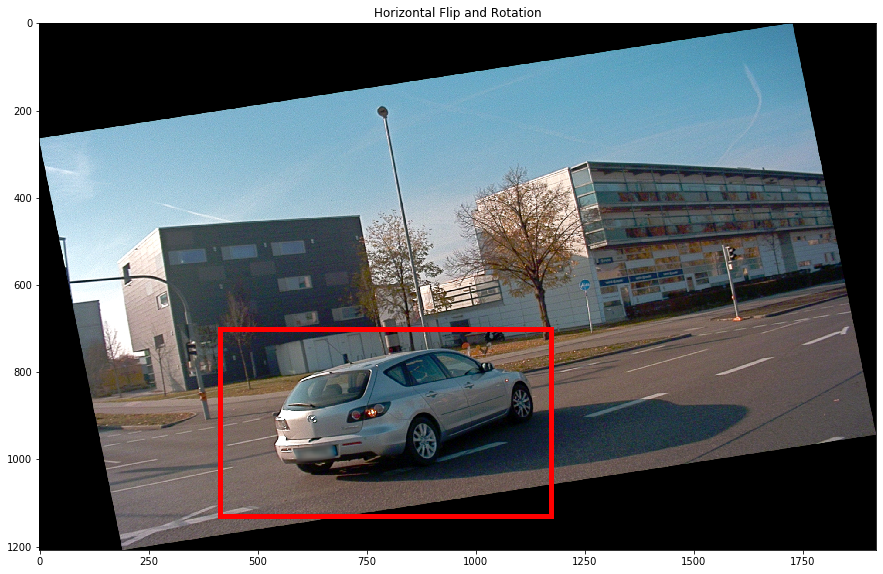

In [20]:
figure, ax = plt.subplots(1, figsize=(15,15))
img = plt.imread(cur_dir+s['imageFile'].iloc[0])
bboxes = s[['x1','y1','x2','y2']].values.reshape((1,4))
transforms = Sequence([HorizontalFlip(), Rotate(10)])
imgR, bboxesR = transforms(img, bboxes)

topleft_x = bboxesR[0][0]
topleft_y = bboxesR[0][1]
bottom_right_x = bboxesR[0][2]
bottom_right_y = bboxesR[0][3]
rect1 = plt.Rectangle((topleft_x,topleft_y),(bottom_right_x-topleft_x),(bottom_right_y-topleft_y), 
                         edgecolor='r', facecolor='none', linewidth=5)

_ = ax.add_patch(rect1)
_ = plt.imshow(imgR)
_ = plt.title('Horizontal Flip and Rotation')